# Dataset

### Download the data from kaggle

In [ ]:
import os

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d scribbless/another-anime-face-dataset

 99% 1.43G/1.44G [00:16<00:00, 116MB/s] 
100% 1.44G/1.44G [00:16<00:00, 95.1MB/s]


In [ ]:
data_dir = 'Dataset/'

In [ ]:
!unzip -q another-anime-face-dataset.zip
!mv animefaces256cleaner {data_dir}
!rm another-anime-face-dataset.zip

### Preprocessing

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
files = [data_dir + file for file in os.listdir(data_dir)]
files[:7]

['Dataset/53869131_result.jpg',
 'Dataset/18051079_result.jpg',
 'Dataset/82851300_result.jpg',
 'Dataset/14365936_result.jpg',
 'Dataset/79705063_result.jpg',
 'Dataset/24015603_result.jpg',
 'Dataset/5140671_result.jpg']

In [ ]:
len(files)

92219

In [ ]:
width, height = (64, 64)

def preprocess(file):
    img = tf.io.decode_jpeg(tf.io.read_file(file))
    return tf.image.resize(img, (width, height))/255.

test_img = preprocess(files[0])

In [ ]:
print(test_img.shape)
test_img.dtype

(64, 64, 3)


tf.float32

In [ ]:
batch_size = 64

data = tf.data.Dataset.from_tensor_slices(files)
data = data.map(preprocess).shuffle(1000).batch(batch_size)

len(data)

1441

In [ ]:
def show_16_imgs(data):
    fig, axes = plt.subplots(4, 4, figsize=(14,14))
    sample = data.unbatch().take(16)
    samples = [image for image in sample]

    idx = 0
    for row in range(4):
        for column in range(4):
            axes[row, column].imshow(samples[idx])
            axes[row, column].axis('off')
            idx+=1

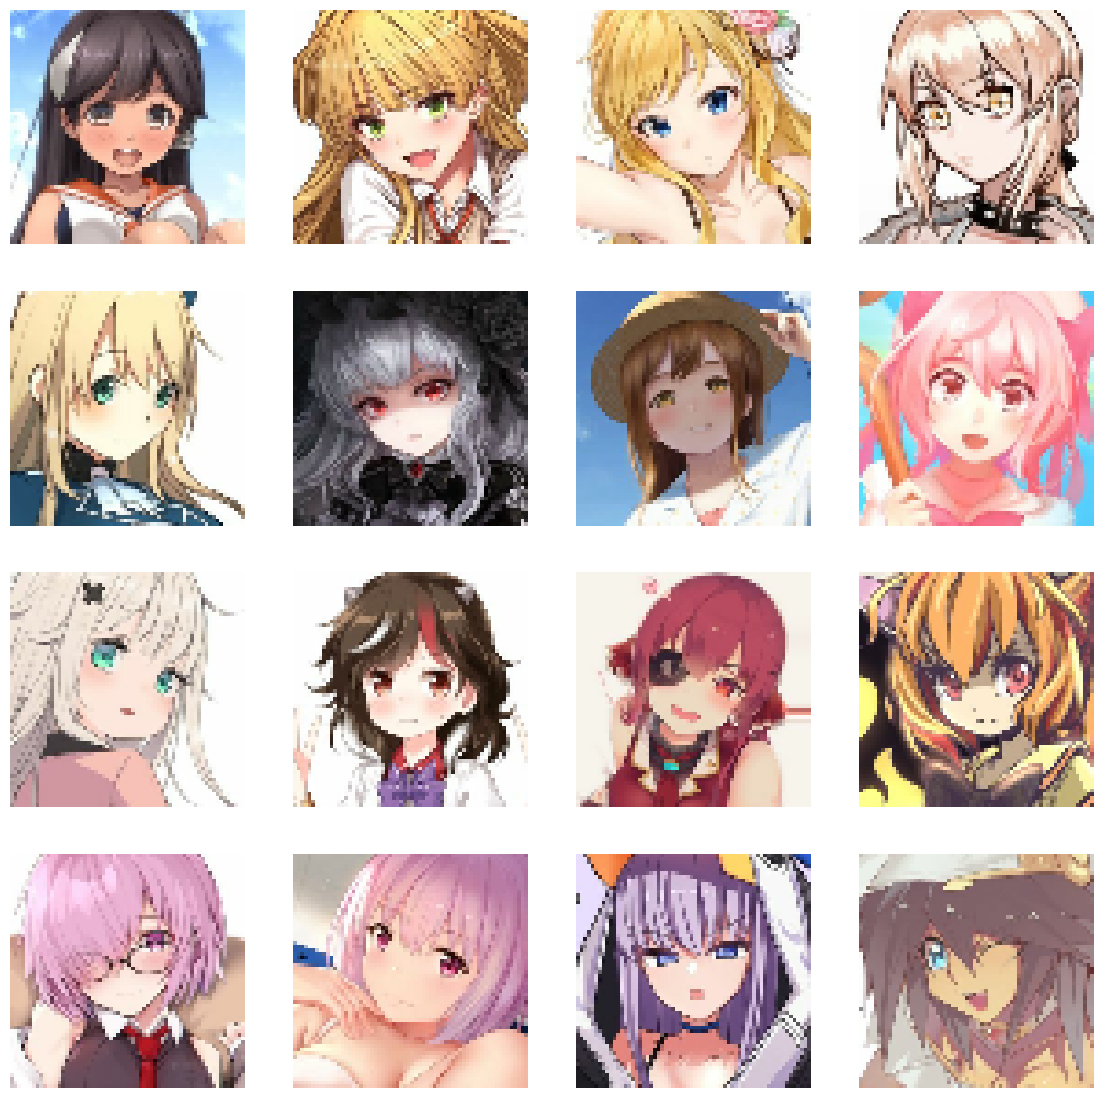

In [ ]:
show_16_imgs(data)

# VAE Model

![img1](vae-diagram.jpg)

### Encoder

In [ ]:
from keras.models import Sequential, Model

from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization,\
                         Lambda, Reshape, Activation, LeakyReLU, Multiply, Add

from keras.activations import selu

from keras.optimizers import Adam

from keras import backend as K

In [ ]:
latent_dim = 256

encoder_input = Input(shape = (width, height, 3))

x = Conv2D(32, kernel_size=5, strides=1, padding='same')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU(0.02)(x)

filter_size = [64, 128, 256, 512]
for i in filter_size:
    x = Conv2D(i, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.02)(x)

x = Flatten()(x)
x = Dense(1024)(x)
x = selu(x)
encoder_output = BatchNormalization()(x)

# sampling layer
z_mu = Dense(latent_dim)(encoder_output)
z_sigma = Dense(latent_dim)(encoder_output)

epsilon = K.random_normal(shape = (tf.shape(z_mu)[0], tf.shape(z_mu)[1]))
sigma = tf.exp(0.5 * z_sigma)

z_eps = Multiply()([sigma, epsilon])
z = Add()([z_mu, z_eps])

encoder = Model(encoder_input, outputs = [z_mu, z_sigma, z])

encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           2432      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)           0         ['batch_normalization[0][0

### Decoder

In [ ]:
from tensorflow.keras.activations import sigmoid

In [ ]:
decoder_input = Input((latent_dim,))

decoder = Dense(1024)(decoder_input)
decoder = BatchNormalization()(decoder)
decoder = selu(decoder)

decoder = Dense(8192, activation = 'selu')(decoder)
decoder = Reshape((4, 4, 512))(decoder)

filters = 256
for _ in range(4):
    decoder = Conv2DTranspose(filters, 5, 2, padding = 'same')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU(0.02)(decoder)
    filters /= 2

decoder = Conv2DTranspose(3, 5, padding = 'same')(decoder)
decoder = sigmoid(decoder)

decoder = Model(decoder_input, decoder)

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              263168    
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 tf.nn.selu_1 (TFOpLambda)   (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                           

### Losses and VAE Model

![img2](kl-loss.JPG)

In [ ]:
def reconstruction_loss(y, y_pred):
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, sigma):
    return -0.5 * tf.reduce_mean(1 + sigma - tf.square(mu) - tf.exp(sigma))

def vae_loss(y_true, y_pred, mu, sigma):
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, sigma)

In [ ]:
mu, sigma, z = encoder(encoder_input)
decoder_output = decoder(z)

loss = kl_loss(mu, sigma)

vae = Model(encoder_input, decoder_output)
vae.add_loss(loss)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 model (Functional)          [(None, 256),                1327788   ['input_1[0][0]']             
                              (None, 256),                8                                       
                              (None, 256)]                                                        
                                                                                                  
 model_1 (Functional)        (None, 64, 64, 3)            1302086   ['model[0][2]']               
                                                          7                                 

# Training

In [ ]:
from keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
optimizer = Adam(0.0001, 0.5)

In [ ]:
output_dir = "output/"
if not os.path.exists(output_dir): os.mkdir(output_dir)

In [ ]:
def save_images(model, input):
    prediction = model.predict(input)
    fig, axes = plt.subplots(4, 4, figsize = (14, 14))
    idx = 0
    for row in range(4):
        for column in range(4):
            axes[row, column].imshow(prediction[idx])
            axes[row, column].axis("off")
            idx+=1
    plt.savefig(output_dir + "Epoch_{}.jpg".format(epoch))
    plt.close()

In [ ]:
epoch = 0
random_vector = tf.random.normal(shape = (16, latent_dim))
save_images(decoder, random_vector)

1/1 [==============================] - 3s 3s/step


In [ ]:
mse_losses = []
kl_losses = []

epochs = 16

for epoch in range(1, epochs + 1):
    for step, training_batch in tqdm(enumerate(data), total = len(data)):
        with tf.GradientTape() as tape:
            reconstructed = vae(training_batch)
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])

            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())

            kl = sum(vae.losses)
            kl_losses.append(kl.numpy())

            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, vae.trainable_variables)
            optimizer.apply_gradients(zip(grads, vae.trainable_variables))

    save_images(decoder, random_vector)
    print("Epoch: %s - MSE loss: %s - KL loss: %s\n" % (epoch, mse_loss.numpy(), kl.numpy()))

100%|██████████| 1441/1441 [04:39<00:00,  5.15it/s]


1/1 [==============================] - 0s 30ms/step
Epoch: 1 - MSE loss: 0.020930137 - KL loss: 0.38072082



100%|██████████| 1441/1441 [04:39<00:00,  5.15it/s]


1/1 [==============================] - 0s 17ms/step
Epoch: 2 - MSE loss: 0.021733142 - KL loss: 0.40924558



100%|██████████| 1441/1441 [03:34<00:00,  6.72it/s]

1/1 [==============================] - 0s 17ms/step


Epoch: 3 - MSE loss: 0.021620285 - KL loss: 0.42258155



100%|██████████| 1441/1441 [03:32<00:00,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


Epoch: 4 - MSE loss: 0.021610372 - KL loss: 0.4097667



100%|██████████| 1441/1441 [03:32<00:00,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


Epoch: 5 - MSE loss: 0.020329947 - KL loss: 0.42812467



100%|██████████| 1441/1441 [03:29<00:00,  6.86it/s]


1/1 [==============================] - 0s 39ms/step
Epoch: 6 - MSE loss: 0.021080837 - KL loss: 0.4385936



100%|██████████| 1441/1441 [03:29<00:00,  6.88it/s]


1/1 [==============================] - 0s 17ms/step
Epoch: 7 - MSE loss: 0.020315384 - KL loss: 0.41760227



100%|██████████| 1441/1441 [03:26<00:00,  6.97it/s]

1/1 [==============================] - 0s 17ms/step


Epoch: 8 - MSE loss: 0.021179061 - KL loss: 0.43867403



100%|██████████| 1441/1441 [03:26<00:00,  6.99it/s]


1/1 [==============================] - 0s 27ms/step
Epoch: 9 - MSE loss: 0.020801978 - KL loss: 0.42406845



100%|██████████| 1441/1441 [03:25<00:00,  7.02it/s]


1/1 [==============================] - 0s 17ms/step
Epoch: 10 - MSE loss: 0.019084603 - KL loss: 0.43372127



100%|██████████| 1441/1441 [03:33<00:00,  6.76it/s]


1/1 [==============================] - 0s 33ms/step
Epoch: 11 - MSE loss: 0.019321721 - KL loss: 0.4279275



100%|██████████| 1441/1441 [03:25<00:00,  7.02it/s]


1/1 [==============================] - 0s 28ms/step
Epoch: 12 - MSE loss: 0.019532222 - KL loss: 0.46171346



100%|██████████| 1441/1441 [03:27<00:00,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


Epoch: 13 - MSE loss: 0.019394893 - KL loss: 0.4556197



100%|██████████| 1441/1441 [03:30<00:00,  6.86it/s]


1/1 [==============================] - 0s 17ms/step
Epoch: 14 - MSE loss: 0.020308748 - KL loss: 0.47032914



100%|██████████| 1441/1441 [03:32<00:00,  6.78it/s]

1/1 [==============================] - 0s 17ms/step


Epoch: 15 - MSE loss: 0.019188052 - KL loss: 0.4750994



100%|██████████| 1441/1441 [03:39<00:00,  6.56it/s]


1/1 [==============================] - 0s 27ms/step
Epoch: 16 - MSE loss: 0.019149968 - KL loss: 0.4563012



# Show the results

In [ ]:
from PIL import Image

In [ ]:
results_files = [output_dir + file_name for file_name in os.listdir(output_dir)]
len(results_files)

18

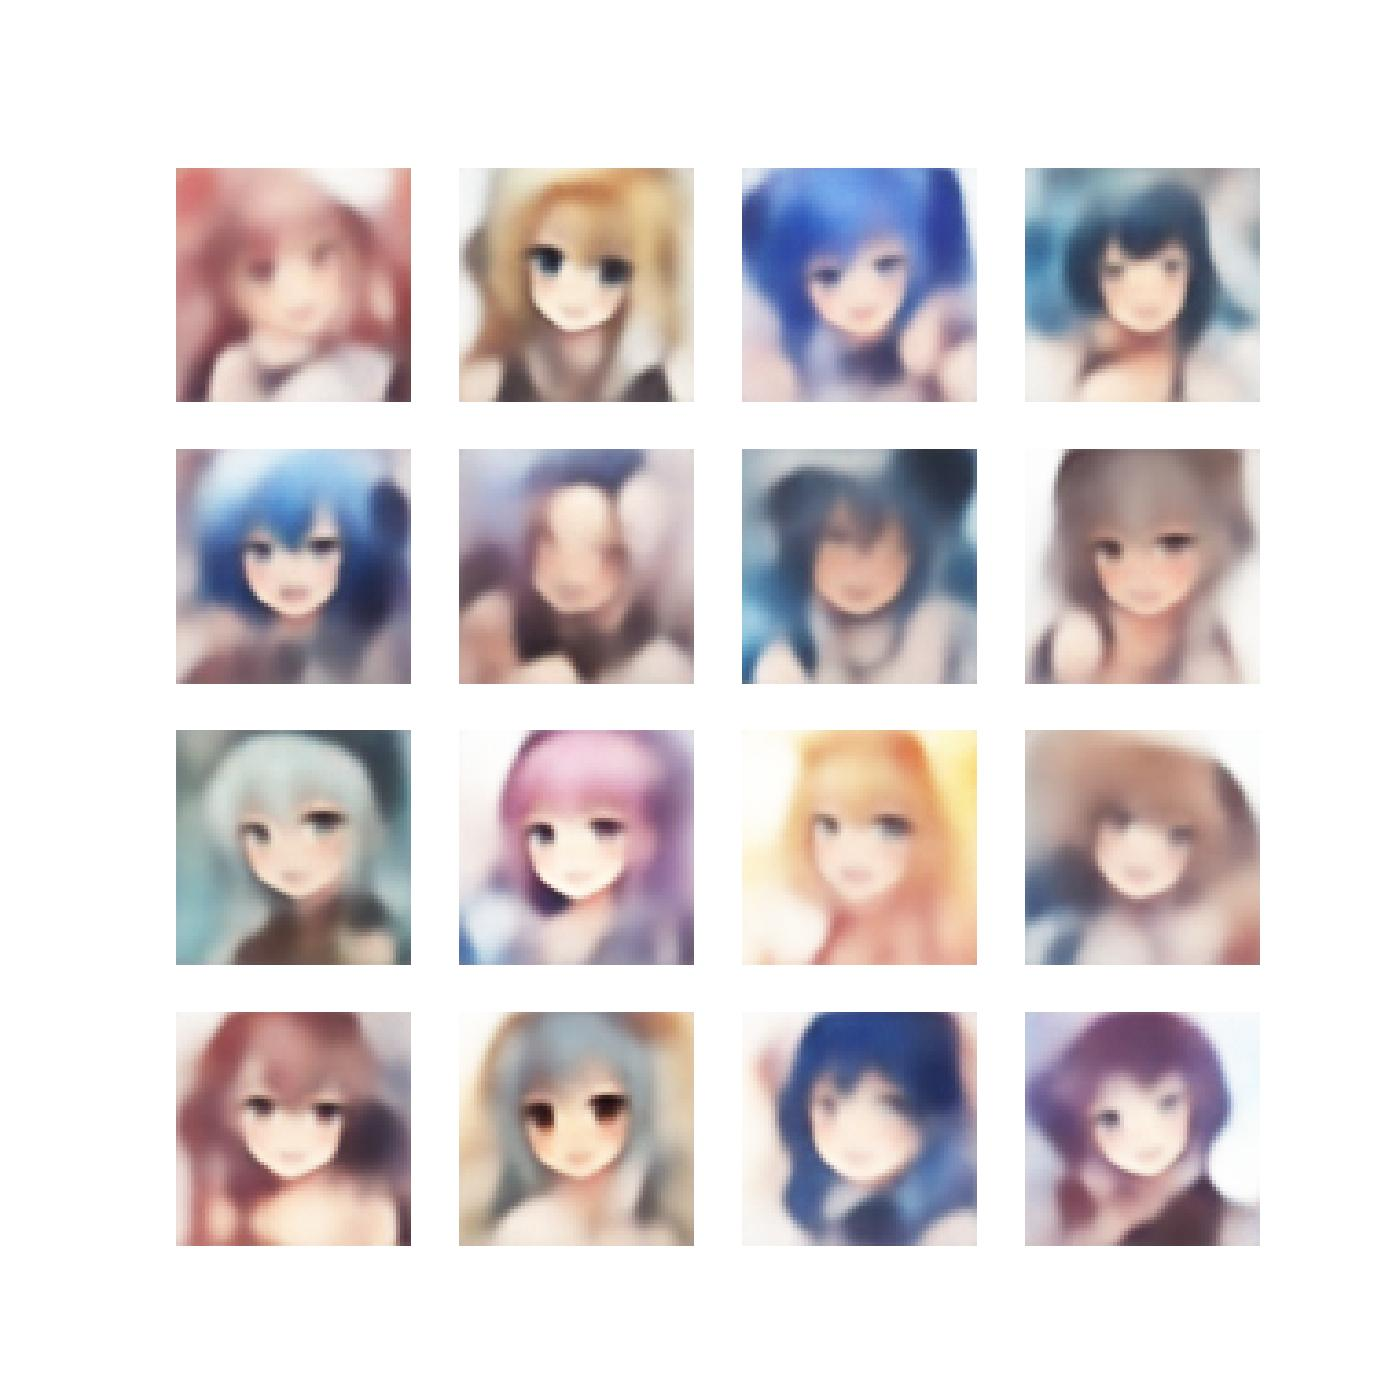

In [ ]:
Image.open(results_files[5])

In [ ]:
Image.open(results_files[1])